In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Load the dataset
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# Build vocaulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [21]:
# Build the dataset

block_size = 3 # context length
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size # initial context = . . . or 0 0 0
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [22]:
# Create C: the embedding matrix
C = torch.randn((27, 2)) # each of 27 chars gets a 2D embedding

In [23]:
C[5]

tensor([ 1.1696, -0.1612])

In [24]:
# We will not use this as it is slower than indexing
F.one_hot(torch.tensor(5), num_classes=27).float() @ C  # one-hot multiplication is same as indexing: 1x27 @ 27x2 = 1x2

tensor([ 1.1696, -0.1612])

In [25]:
# Indexing flexibility
print(C[5])
print(C[[1, 2, 3]])
print(C[torch.tensor([1, 2, 3])])
print(C[torch.tensor([[5, 6, 7], [1, 2, 3]])])

C[X].shape

tensor([ 1.1696, -0.1612])
tensor([[-2.1353,  1.3656],
        [-1.0944, -0.9554],
        [-0.4383,  0.8352]])
tensor([[-2.1353,  1.3656],
        [-1.0944, -0.9554],
        [-0.4383,  0.8352]])
tensor([[[ 1.1696, -0.1612],
         [-0.6932, -1.2125],
         [-0.1507,  0.6150]],

        [[-2.1353,  1.3656],
         [-1.0944, -0.9554],
         [-0.4383,  0.8352]]])


torch.Size([228146, 3, 2])

In [26]:
C[X[13, 2]], C[X][13, 2]

(tensor([-2.1353,  1.3656]), tensor([-2.1353,  1.3656]))

In [27]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [28]:
W1 = torch.randn((6, 100)) # 6 input features (2D per char, 3 chars), 100 neurons
b1 = torch.randn(100)

# We want to do: emb @ W1 + b1, but shapes don't match, we need to concatenate embedding

In [29]:
# What we want:
print(emb[:, 0, :].shape)
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # but this is hardcoded

torch.Size([228146, 2])


torch.Size([228146, 6])

In [30]:
# First good method:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([228146, 6])

In [31]:
# Second better method:
a = torch.arange(18)
print(a.view(2, 9))
print(a.view(2, 3, 3))
print(a.storage()) # view is efficient, it does not use extra memory

emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1) # view concatenates exactly as we desire

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]


RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
h = emb.view(32, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [ ]:
# Add activation function
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer activations

# Check for correct broadcasting
# 32, 100 +
#   , 100 -> 1, 100 -> 32 (copies), 100 -> what we want

In [ ]:
# Final output layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
print(logits.shape)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
print(prob.shape)

torch.Size([32, 27])
torch.Size([32, 27])


In [ ]:
print(Y)
prob[torch.arange(32), Y] # probabilities tha model predicts the next character correctly (very low for untrained model)
loss = - prob[torch.arange(32), Y].log().mean() # negative log likelihood
loss

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


tensor(22.1195)

# Rewrite

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # Embedding matrix
W1 = torch.randn((6, 100), generator=g) # Weights for hidden layer
b1 = torch.randn(100, generator=g) # Bias for hidden layer
W2 = torch.randn((100, 27), generator=g) # Weights for output layer
b2 = torch.randn(27, generator=g) # Bias for output layer
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # total parameters

3481

In [ ]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp() # (32, 27)
prob = counts / counts.sum(1, keepdim=True)
# loss = - prob[torch.arange(32), Y].log().mean()
# loss

# Cross-entropy

In [ ]:
loss = F.cross_entropy(logits, Y) # much more efficient and numerically stable
loss

tensor(19.5052)

numerically stable example

In [ ]:
logits = torch.tensor([-5, -3, 0, 100])
counts = logits.exp() # e^100 is very large = inf, so prob = nan
prob = counts / counts.sum()
prob

tensor([0., 0., 0., nan])

In [ ]:
logits = torch.tensor([-100, -3, 0, 100]) - 100 # subtract max logit for numerical stability (PyTorch internally)
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

# Training loop

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # Embedding matrix
W1 = torch.randn((6, 100), generator=g) # Weights for hidden layer
b1 = torch.randn(100, generator=g) # Bias for hidden layer
W2 = torch.randn((100, 27), generator=g) # Weights for output layer
b2 = torch.randn(27, generator=g) # Bias for output layer
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # total parameters

3481

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# optimize learning rates
lre = torch.linspace(-3, 0, steps=1000) # learning rate exponents -> to step through exponential lr's
lrs = 10**lre # or we use torch.logspace
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [ ]:
lri = []
lrexp = []
lossi = []

for i in range(10000):  

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2) batch of 32 data points
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward()

    # lr = lrs[i]
    # lr = 1e-1 # optimal lr
    lr = 1e-2 # learning rate decay after long training
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    # lri.append(lr)
    # lrexp.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

1.9965808391571045


# Batching

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([159019, 157628, 196581, 179311, 212555, 122367, 133993, 105954, 196463,
         96215, 212952, 131730, 139677,  40153, 153391,  40194, 212253, 216978,
         95740,  79025, 147220, 204355, 104147, 221278,  41601, 128360, 166228,
         82791, 207755,  32286, 202364, 111316])

In [ ]:
# Total loss on all data
emb = C[X] # (32, 3, 2) batch of 32 data points
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3122, grad_fn=<NllLossBackward0>)

# Learning rates
How do we know if the learning rate is good? -> try all different lr's

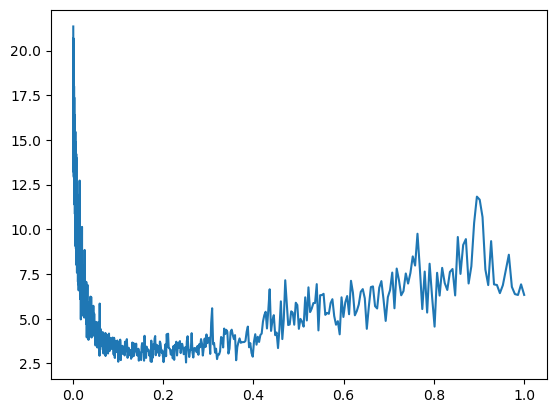

In [ ]:
plt.plot(lri, lossi)

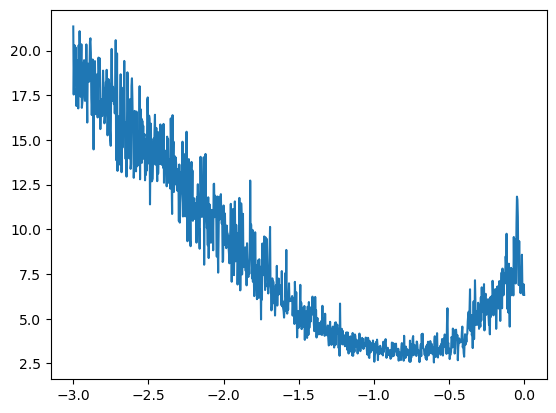

In [ ]:
plt.plot(lrexp, lossi)

# Learning rate decay
after long training at optimal lr, you can take lower lr to optimize the last bit
we get final loss of around 2.31 < 2.45 of bigram model

the larger model params -> more capable at overfitting -> lower loss -> but not necessarily good

We want train, validation, and test data to make sure model doesn't overfit

# Splitting datasets

In [32]:
# Dataset builder

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size # initial context = . . . or 0 0 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [53]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # Embedding matrix (10D embeddings)
W1 = torch.randn((30, 200), generator=g) # Weights for hidden layer
b1 = torch.randn(200, generator=g) # Bias for hidden layer
W2 = torch.randn((200, 27), generator=g) # Weights for output layer
b2 = torch.randn(27, generator=g) # Bias for output layer
parameters = [C, W1, b1, W2, b2]

In [54]:
sum(p.nelement() for p in parameters) # total parameters

11897

In [55]:
for p in parameters:
    p.requires_grad = True

In [56]:
lre = torch.linspace(-3, 0, steps=1000) # learning rate exponents -> to step through exponential lr's
lrs = 10**lre # or we use torch.logspace

In [57]:
lri = []
lrexp = []
lossi = []

stepi = []

In [58]:
for i in range(200000):  

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) batch of 32 data points
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay after long training
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    # lri.append(lr)
    # lrexp.append(lre[i])
    lossi.append(loss.log10().item()) # change to log

    stepi.append(i)

print(loss.item())

2.536569833755493


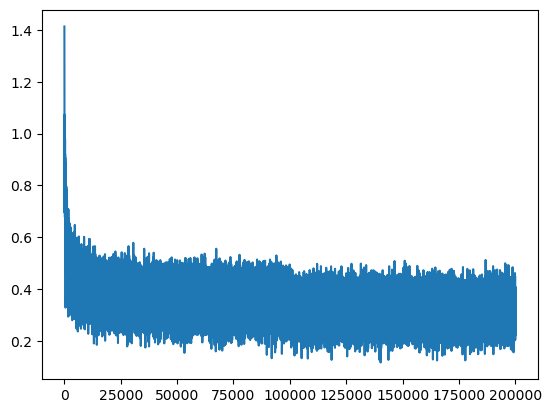

In [59]:
plt.plot(stepi, lossi)

In [60]:
# Evaluate on dev
emb = C[Xdev] # (32, 3, 2) batch of 32 data points
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1656, grad_fn=<NllLossBackward0>)

In [61]:
# Evaluate on training set
emb = C[Xtr] # (32, 3, 2) batch of 32 data points
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1215, grad_fn=<NllLossBackward0>)

The training loss is about equal to validation loss -> We are NOT overfitting (when loss_tr << loss_val)

When they are about equal = sign we are UNDERFITTING -> We need to increase parameters

# Increase parameters
increase neurons -> This helps the loss becomes lower, but still same training and validation loss -> bottleneck could be embedding dimension

plot 2D embedding

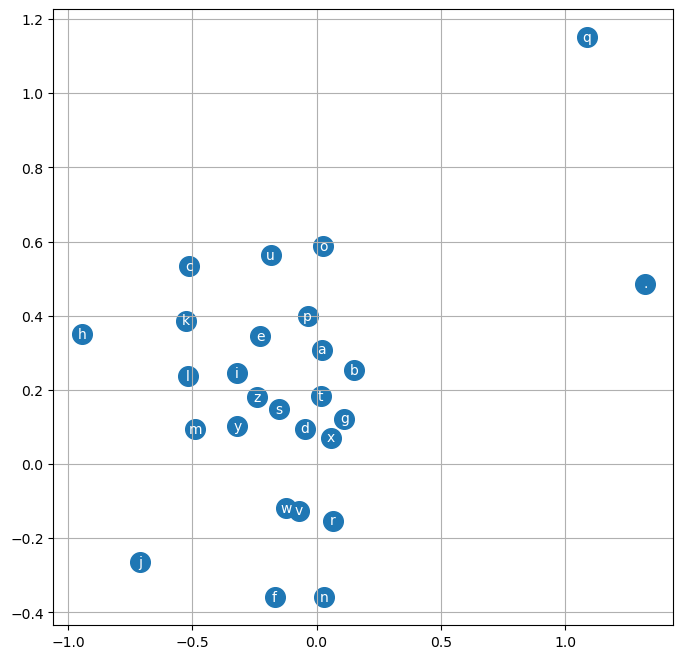

In [51]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

increase embedding dimension -> training loss is slightly lower now than validation (2.16 vs 2.18)

# Learning rate reduction during training
lr = 0.1 during first 100 000 it, then 0.01 for remaining it -> tr_loss = 2.12, val_loss = 2.16

# Sampling from model

In [62]:
g = torch.Generator().manual_seed(2147483647)
block_size = 3

for _ in range(20):
    out = []
    context = [0] * block_size # initial context = . . . or 0 0 0
    while True:
        emb = C[torch.tensor([context])] # (1, context length=3, embedding dim=10)
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dex.
maleah.
makilah.
tyhamellissana.
nylande.
kaida.
samiyah.
javer.
gotti.
molie.
cavo.
keytedo.
kaley.
maside.
eniavier.
ratls.
mhineven.
tahlas.
kashra.
antil.
